In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
syn_T = 351
C_den = torch.Tensor([0]).reshape((1,1))
sub_no = C_den.shape[0]

batch_size = 2094

syn_basis_no = 2
hist_basis_no = 3
spike_status = True
hist_T = 251

In [3]:
Ensyn = torch.tensor([629])
Insyn = torch.tensor([120])
N = Ensyn.item() + Insyn.item()

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

# Pre-Fit Params (1 Subunit)

In [4]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T).cuda()
fit_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/pre_fit/pre1_nospike_s2_h3_shglm_i17000.pt"))
fit_shGLM.train()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
adjust_K_hist = torch.ones(sub_no, hist_basis_no)*(0.05)
adjust_thresh = torch.ones(sub_no)*7
adjust_spike_size = torch.ones(sub_no)*5
adjust_thresh_scale = torch.ones(sub_no)*5

with torch.no_grad():
    fit_shGLM.K_hist = nn.Parameter(adjust_K_hist.float(), requires_grad=True)
    fit_shGLM.thresh = nn.Parameter(adjust_thresh.float(), requires_grad=True)
    fit_shGLM.spike_size = nn.Parameter(adjust_spike_size, requires_grad=True)
    fit_shGLM.thresh_scale = nn.Parameter(adjust_thresh_scale, requires_grad=True)
    
fit_shGLM.cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 1
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

17906
17906


In [8]:
no_spike_bool = True
spike_bool = True

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = no_spike_bool
fit_shGLM.Delta.requires_grad = no_spike_bool
#fit_shGLM.W.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = no_spike_bool

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool
#fit_shGLM.W_hist.requires_grad = spike_bool

In [9]:
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.001)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0025)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.00025)


criterion = nn.MSELoss(reduction="mean")

In [10]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/pre_fit/pre1_spike5_s2_h3_shglm_i"+str(i)+".pt")
    


<ipython-input-10-59e0c78ed87d>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 2.134153540764032 0.8454778414600788 0.7139293510568707
TEST 100 2.1371910414816266 0.8452579128830182 0.7176471701967662
TEST 200 1.8878590107553306 0.8633106550465242 0.7897415342905932
TEST 300 1.8388313520695654 0.8668604744664669 0.7162609563499541
TEST 400 1.79601487092915 0.8699605771827327 0.7197575425217256
TEST 500 1.7669255310989342 0.8720667740785897 0.6502068470062785
TEST 600 1.7053013551060794 0.8765286371164971 0.7821718431991865
TEST 700 1.846704452482442 0.8662904272104548 0.8298292690502292
TEST 800 2.720061323150032 0.8030555259218866 0.5803773784462578
TEST 900 1.652286640596959 0.8803671370079942 0.73601242796311
TEST 1000 1.971066708165302 0.8572860498402644 0.7793046716162688
TEST 1100 1.644376101751463 0.8809398950911429 0.6844761580138733
TEST 1200 1.6575530519362136 0.8799858255964237 0.64256791936868
TEST 1300 2.091623538369967 0.8485572017133705 0.8031978444756235
TEST 1400 1.614595888630299 0.883096114210117 0.7447585367612236
TEST 1500 1.7673290656

KeyboardInterrupt: 

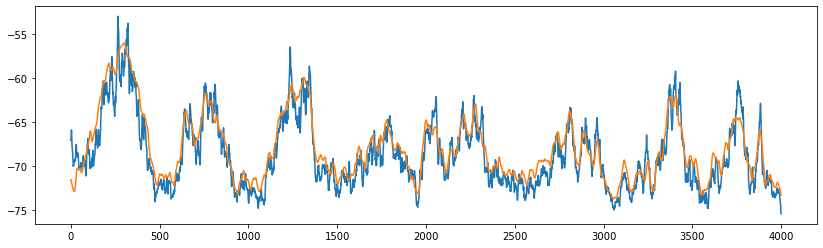

In [13]:
plt.figure(figsize=(14,4))
plt.plot(test_V_ref.cpu().detach().numpy()[:4000])
plt.plot(test_pred.cpu().detach().numpy()[:4000])


In [14]:
for name, param in fit_shGLM.named_parameters():
    if param.requires_grad:
        print(name, param.data)

V_o tensor([-79.1327], device='cuda:0')
K_syn tensor([[[-0.0430,  0.0606],
         [ 0.0872, -0.0656]]], device='cuda:0')
syn_basis_tau tensor([1.8845, 2.1895], device='cuda:0')
Delta tensor([4.9527], device='cuda:0')
C tensor([2.7805], device='cuda:0')
Theta tensor([0.0047], device='cuda:0')
thresh tensor([6.9620], device='cuda:0')
thresh_scale tensor([4.9119], device='cuda:0')
spike_size tensor([4.7979], device='cuda:0')
hist_basis_tau tensor([2.2247, 2.8350, 2.9540], device='cuda:0')
K_hist tensor([[0.0894, 0.4085, 0.5070]], device='cuda:0')


# See Pre-Fit Params

In [10]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T).cuda()
fit_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/pre_fit/pre1_nospike_s3_h3_shglm_i17000.pt"))

<All keys matched successfully>

In [11]:
for name, param in fit_shGLM.named_parameters():
    if param.requires_grad:
        print(name, param.data)

V_o tensor([-74.8817], device='cuda:0')
K_syn tensor([[[ 0.0506, -0.0364],
         [-0.1064,  0.0716],
         [ 0.0970, -0.0528]]], device='cuda:0')
syn_basis_tau tensor([1.5266, 2.2565, 2.7229], device='cuda:0')
Delta tensor([4.7492], device='cuda:0')
C tensor([3.1747], device='cuda:0')
Theta tensor([0.6681], device='cuda:0')
thresh tensor([85.], device='cuda:0')
thresh_scale tensor([100.], device='cuda:0')
spike_size tensor([4.], device='cuda:0')
hist_basis_tau tensor([1.7000, 2.2000, 2.7000], device='cuda:0')
K_hist tensor([[0.0250, 0.0250, 0.0250]], device='cuda:0')


# Test Pre-Fit

In [4]:
final_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T).cuda()
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/pre_fit/pre1_spike5_s2_h3_shglm_i6000.pt"))
final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

#test_V_final = test_V_final[:4000]
#test_V_ref = test_V_ref[:4000]

0.9466005386978913


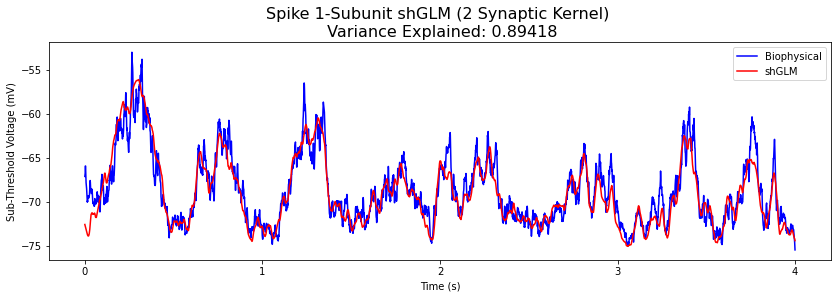

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]-1.8, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Spike 1-Subunit shGLM (2 Synaptic Kernel) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()
#

plt.savefig("/media/hdd01/sklee/shglm/biophysical/pre1_spike5_s2_h3_shGLM.png", dpi=150, bbox_inches='tight')

In [9]:
for name, param in final_shGLM.named_parameters():
    if param.requires_grad:
        print(name, param.data)

V_o tensor([-74.1293], device='cuda:0')
K_syn tensor([[[ 0.1467, -0.0373]]], device='cuda:0')
Delta tensor([4.5825], device='cuda:0')
C tensor([2.7263], device='cuda:0')
Theta tensor([1.7552], device='cuda:0')
thresh tensor([85.], device='cuda:0')
spike_size tensor([4.], device='cuda:0')
K_hist tensor([[-0.0250, -0.0250, -0.0250]], device='cuda:0')
